<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%202/02_2_APIs_SNDGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enriquecimiento de entidades espaciales


## Servicio de Normalización de Datos Geográficos (MM)

En en ejemplo anterior vimos qué es un geocodificador y cómo se puede obtener las coordenadas geográficas de un punto específico a partir de la API de Google. Ahora vamos a ampliar un poco el espectro e introduciremos otra herramienta del estilo que desarrolló el Gobierno Nacional. Esta es la [API del Servicio de Normalización de Datos Geográficos de Argentina](https://datosgobar.github.io/georef-ar-api/), una herramienta muy útil para normalizar entidades territoriales, enriquecerlas u obtener información como sus coordenadas.


### Explorando un contexto de uso real

<figure>
<center>
<img src='https://drive.google.com/uc?id=1S5Rpva1bb6r5j87D2kkktSXRCiwDNYzb' />
<figcaption></figcaption></center>
</figure>

Supongamos necesitamos trabajar con edificios que han sido catalogados como patrimonio histórico de la ciudad. 

A continuación veremos un [listado de fachadas](https://data.buenosaires.gob.ar/dataset/fachadas) con certificado de conservación. Este dataframe lo bajamos del portal de datos del Gobierno de la Ciudad de Buenos Aires, comúnmente conocido como [data buenos aires](https://data.buenosaires.gob.ar/dataset) - un sitio de consulta de datasets de bastante utilidad.

In [1]:
# Damos un primer vistazo a nuestro DataFrame
import pandas as pd

In [2]:
fachadas = pd.read_csv('https://storage.googleapis.com/python_mdg/data_cursos/fachadas.csv')

In [3]:
# Como vemos, se trata de un dataset de 26489 registros
len(fachadas)

26489

In [4]:
# Con información geográfica relativa a la sección, manzana, la parcela y dirección donde se encuentra cada fachada
fachadas.columns

Index(['seccion', 'manzana', 'parcela', 'partida', 'calle_nombre',
       'calle_altura', 'vencimiento_certificado'],
      dtype='object')

In [5]:
fachadas.head(2)

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30


In [6]:
# Un total de 26464 partidas únicas
len(fachadas.partida.unique())

26464

In [7]:
fachadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26489 entries, 0 to 26488
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   seccion                  26489 non-null  int64  
 1   manzana                  26489 non-null  object 
 2   parcela                  26489 non-null  object 
 3   partida                  26474 non-null  float64
 4   calle_nombre             26475 non-null  object 
 5   calle_altura             26475 non-null  float64
 6   vencimiento_certificado  26458 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB


In [8]:
import datetime

In [9]:
def to_datetime(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

In [10]:
fechas = fachadas['vencimiento_certificado'].fillna('0000-00-00')

Sabemos que las fechas con mayor cantidad de vencimientos son en octubre y junio de 2020...

In [11]:
fechas[fechas!='0000-00-00'].map(to_datetime).mode()

0   2020-06-06
1   2020-10-03
dtype: datetime64[ns]

In [12]:
# y en marzo del 2019, el vencimiento más viejo
fechas[fechas!='0000-00-00'].map(to_datetime).min()

Timestamp('2019-03-12 00:00:00')

Con lo cual, sabemos que se trata de un registro bastante actualizado, con partidas que vencen (mayormente) entre 2020 y 2040...

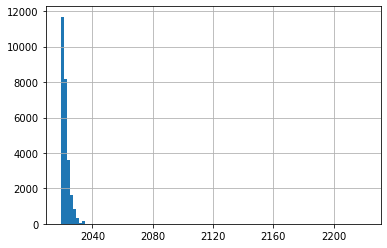

In [13]:
fechas[fechas!='0000-00-00'].map(to_datetime).hist(bins=100);

In [14]:
# y, posiblemente, algún registro erróneo (como se puede apreciar en la cola de nuestro histograma)
fechas[fechas!='0000-00-00'].map(to_datetime).max()

Timestamp('2220-11-20 00:00:00')

Pero lo más importante, aunque este dataset cuenta con referencias geográficas, no sería tan fácil plotear estos registros en un mapa. Si bien no es algo imposible, esto nos demandaría cierto preprocesamiento. Básicamente, porque estas referencias no son más que datos de tipo string. Podríamos construir un código único con las columnas de sección, manzana y parcela y mergearlos con algún shapefile de manzanas. Aunque, para ser más precisos, trataremos de usar la dirección y la altura para conseguir la latitud y la longitud. De esta manera, utilizaremos las coordenadas geográficas de estas direcciones y plotearemos un mapa de puntos para ubicar nuestras fachadas históricas. Comencemos!

### Trabajando sobre los datos

In [15]:
# Como la altura es un valor numérico,
fachadas.calle_altura.dtype

dtype('float64')

In [16]:
# vamos a reemplazar los NaN por cero
fachadas.calle_altura.fillna(0, inplace=True)

In [17]:
# y ver cuántos son. Como es bajo el número vamos a suponer que los faltantes corresponden a la altura 0.
len(fachadas.loc[fachadas.calle_altura == 0])

14

In [18]:
# tenemos 14 casos perdidos, podemos descartarlos
len(fachadas[fachadas.calle_nombre.isna()])

14

In [19]:
fachadas_ = fachadas[~fachadas.calle_nombre.isna()].copy()

In [20]:
fachadas_.head()

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30
2,17,14,27,173288.0,SARMIENTO,4579.0,2019-05-03
3,42,16,1,140186.0,DIRECTORIO AV.,1706.0,2019-06-10
4,11,65,6,442215.0,ALVEAR AV.,1974.0,2019-06-16


In [21]:
# imputamos con la fecha mas frecuente
fachadas_.vencimiento_certificado.fillna(fachadas_.vencimiento_certificado.mode()[0], inplace=True)

In [22]:
# Armamos un único string
fachadas_['direccion'] = fachadas_['calle_nombre'] + ' ' + fachadas_['calle_altura'].astype(str)

In [23]:
fachadas_['direccion'].head(5)

0    ALVAREZ, JULIAN 2531.0
1    LAMARCA, EMILIO 1014.0
2          SARMIENTO 4579.0
3     DIRECTORIO AV. 1706.0
4         ALVEAR AV. 1974.0
Name: direccion, dtype: object

### Utilizando el servicio

In [24]:
# Importemos los módulos necesarios para conectarnos con el servicio de la API
import requests
import urllib

#### Hacer un request?

Para utilizar esta API, es necesario trabajar con la librería [requests](https://docs.python-requests.org/es/latest/user/quickstart.html). En líneas muy generales, hacer un `request` es hacer un pedido de información a algún lado. Implica hacer una petición y obtener una respuesta como resultado. Pero una petición y una respuesta entre quiénes?

`HTTP` o *Hypertext Transfer Protocol* refiere a una serie de protocolos diseñados para establecer comunicación entre un servidor y sus clientes. Por el momento, quedemonos con la idea de que nosotros somos los clientes que, por medio de una URL o dirección hacemos un pedido de información a un servidor que aloja los recursos de la API.





#### Tipos de peticiones

Existen distintas formas de comunicarse con un servidor. `GET` y `POST` son dos tipos diferentes de peticiones HTTP ([en este articulo tienen una descripción más completa](https://lazaroibanez.com/difference-between-the-http-requests-post-and-get-3b4ed40164c1)). La principal diferencia es que GET se usa para ver algo tal como está, es decir, sin cambiar nada. Mientras que POST, sí permite actualizar o modificar una petición en base a información o instrucciones específicas que enviemos. Cortito y al pie, con GET vemos y con POST (además de ver) enviamos un payload con el que podemos actualizar o modificar cosas en destino. 

Pero para que exista una petición debe haber alguien que responda no? Los `endpoints` son las URLs de un API o un backend que responden a una petición. Por lo tanto, se podría decir que el endpoint es la URL/dirección de un servicio que utiliza un sitio web para cargar o consumir informacion.

In [25]:
# Construimos un string con la url base que vamos a usar para construir las consultas
API_BASE_URL = "https://apis.datos.gob.ar/georef/api/"

#### GET

In [26]:
endpoint = "provincias"
nombre = {'nombre': 'San Juan'}

In [27]:
url = "{}{}?{}".format(API_BASE_URL, endpoint, urllib.parse.urlencode(nombre))
r1 = requests.get(url).json()[endpoint]

In [28]:
r1

[{'centroide': {'lat': -30.8653679979618, 'lon': -68.8894908486844},
  'id': '70',
  'nombre': 'San Juan'}]

#### POST

In [29]:
endpoint = "direcciones"
nombre = fachadas_['direccion'].iloc[0]
data = {endpoint: [{"direccion": nombre,
                    "departamento":'Comuna',
                    "max":1}]
        }
url = API_BASE_URL + endpoint
r2 = requests.post(url, json=data, headers={"Content-Type": "application/json"}).json()

In [30]:
r2

{'resultados': [{'cantidad': 1,
   'direcciones': [{'altura': {'unidad': None, 'valor': 2531.0},
     'calle': {'categoria': 'CALLE',
      'id': '0209801007040',
      'nombre': 'JULIAN ALVAREZ'},
     'calle_cruce_1': {'categoria': None, 'id': None, 'nombre': None},
     'calle_cruce_2': {'categoria': None, 'id': None, 'nombre': None},
     'departamento': {'id': '02098', 'nombre': 'Comuna 14'},
     'localidad_censal': {'id': '02000010',
      'nombre': 'Ciudad Autónoma de Buenos Aires'},
     'nomenclatura': 'JULIAN ALVAREZ 2531.0, Comuna 14, Ciudad Autónoma de Buenos Aires',
     'piso': None,
     'provincia': {'id': '02', 'nombre': 'Ciudad Autónoma de Buenos Aires'},
     'ubicacion': {'lat': -34.586199585983984, 'lon': -58.41378826532734}}],
   'inicio': 0,
   'parametros': {'departamento': 'Comuna',
    'direccion': {'altura': {'unidad': None, 'valor': '2531.0'},
     'calles': ['ALVAREZ JULIAN'],
     'piso': None,
     'tipo': 'simple'},
    'max': 1},
   'total': 1}]}

Ahora que ya tenemos nuestras direcciones listas y que sabemos lo que es hacer un GET/POST, veamos un primer ejemplo para enriquecer nuestras entidades geográficas revisando algunos de los [ejemplos en python](https://datosgobar.github.io/georef-ar-api/python-usage/).

#### Consultas a granel!

Por medio de la función `similar_bulk` se construirá un diccionario con el listado de direcciones. Se utilizará el parámetro `endpoint`, con el nombre de lo que será la llave con la que se accederá a una lista de diccionarios. Cada uno de esos diccionarios contará con la key `dirección` que dará acceso al `str` que construimos más arriba con el nombre de la dirección. Es decir, la lista de direcciones que pasamos como segundo parámetro. 

También vamos a agregar en el cuerpo de la función una información adicional: el `departamento` al que pertenece nuestra entidad. Así es como se guarda la data que será consultada en el endpoint a través del request. Las keys dirección y departamento son las que darán acceso a la base de datos de donde se consumirá la información adicional que nos traeremos de vuelta. 

Para esto nos fijamos cómo se construye la API BASE para direcciones en los [ejemplos de uso](https://datosgobar.github.io/georef-ar-api/quick-start/). Así, podemos ver que el formato de la consulta es el siguiente: 

```
https://apis.datos.gob.ar/georef/api/direcciones?departamento=merlo&direccion=Florida al 2950
``` 

En nuestro caso, como estamos en la Ciudad de Buenos Aires nuestro departamento serán las Comunas.  Con sólo utilizar la palabra `Comuna` para el parámetro `departamento` que se consumirá en el endpoint será suficiente para traer el valor.  

In [31]:
# Creamos la función
def get_similar_bulk(endpoint, nombres):
    '''
    Normaliza una lista de nombres de alguna de 
    las entidades geográficas.
    ...
    Argumentos:
        endpoint(str): String de texto.
        nombres (iter): Objeto iterable (e.g: list, Series)
    Devuelve:
        list: diccionarios con el resultado de la consulta 
    '''

    # realiza consulta a la API
    data = {
        endpoint: [
            {"direccion": nombre,
             "departamento":'Comuna',
             "max":5} for nombre in nombres
    ]}
    url = API_BASE_URL + endpoint
    results = requests.post(
        url, json=data, headers={"Content-Type": "application/json"}
    ).json()
    
    try:
        parsed_results = [
            single_result[endpoint][0] if single_result[endpoint] else {'Sin dato'}
            for single_result in results["resultados"]
        ]
        print('Consulta realizada: %r resultados obtenidos' % len(parsed_results))

    except:
        print('Excediste el limite de consultas')
        parsed_results = {'Sin dato'}

    return parsed_results

Si comparamos la función con la del ejemplo provisto en la web de la API se puede identificar que agregamos un `try`/`except` al final. Antes de usar este tipo de servicios, es recomendable leer las [condiciones de uso](https://datosgobar.github.io/georef-ar-api/terms/). En el caso de esta API, las [consultas por lote](https://datosgobar.github.io/georef-ar-api/bulk/) tienen límites máximos. Veamos qué pasa si no los respetamos...  

In [32]:
# Este es el total de direcciones que deberíamos consultar
len(fachadas_.direccion)

26475

In [33]:
nombres = fachadas_.direccion

In [34]:
# Podemos ver que en algún momento de la consulta, la API dejó de responder y pasamos al bloque except.
direcciones = get_similar_bulk("direcciones", nombres)

Excediste el limite de consultas


Esto es porque la cantidad de consultas en una misma petición no debe superar las `1000`. Nosotros definimos 5 como `max`, con lo cual si ahora vamos por 999 no deberían tener ningún problema en hacer la consulta.

In [35]:
import numpy as np

In [36]:
def consultas(totales):
    '''
    Aplica get_similar_bulk sobre
    la serie de direcciones de un df
    ...
    Argumentos:
        totales (int): límite superior del intervalo.
    Devuelve:
        list: diccionarios con el resultado de cada consulta 
    '''
    # limite de consultas x petición (rango de 0 a x)
    intervalos = np.arange(0, totales, 999).tolist() 
    intervalos.append(totales)
    
    listado = []
    for i in range(len(intervalos)):
        try:
            print("Iterando de %r a %r casos" % (intervalos[i], intervalos[i+1]))
            I = intervalos[i]
            F = intervalos[i+1]
        except:
            print("Consulta terminada")
            break
        # acá es donde filtramos las consultas a enviar al endpoint
        nombres = fachadas_.direccion.iloc[I:F]
        nombres.fillna('Sin dato', inplace=True)
        direcciones = get_similar_bulk("direcciones", nombres)
        listado.extend(direcciones)
        
    return listado

In [37]:
# Aplicamos get_similar_bulk sobre todo el listado de direcciones de nuestro df
para_enriquecer = consultas(len(fachadas_))

Iterando de 0 a 999 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 999 a 1998 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 1998 a 2997 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 2997 a 3996 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 3996 a 4995 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 4995 a 5994 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 5994 a 6993 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 6993 a 7992 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 7992 a 8991 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 8991 a 9990 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 9990 a 10989 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 10989 a 11988 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 11988 a 12987 casos
Consulta realizada: 999 resultados obtenidos
Iterando de 12987 a 13986

In [38]:
# Tenemos la misma cantidad de casos en nuestra consulta
len(para_enriquecer)

26475

In [39]:
# y en nuestro dataframe original
len(fachadas_)

26475

#### Acomodando la respuesta a nuestra consulta

De cada consulta, nos quedamos con la información que estaba almacenada bajo la key "direcciones". Fíjense en el ejemplo POST y verán que la estructura concuerda.

In [40]:
para_enriquecer[0]

{'altura': {'unidad': None, 'valor': 2531.0},
 'calle': {'categoria': 'CALLE',
  'id': '0209801007040',
  'nombre': 'JULIAN ALVAREZ'},
 'calle_cruce_1': {'categoria': None, 'id': None, 'nombre': None},
 'calle_cruce_2': {'categoria': None, 'id': None, 'nombre': None},
 'departamento': {'id': '02098', 'nombre': 'Comuna 14'},
 'localidad_censal': {'id': '02000010',
  'nombre': 'Ciudad Autónoma de Buenos Aires'},
 'nomenclatura': 'JULIAN ALVAREZ 2531.0, Comuna 14, Ciudad Autónoma de Buenos Aires',
 'piso': None,
 'provincia': {'id': '02', 'nombre': 'Ciudad Autónoma de Buenos Aires'},
 'ubicacion': {'lat': -34.586199585983984, 'lon': -58.41378826532734}}

In [41]:
def enriquece(consultas, atributo):
    '''
    Accede al item de cada key de 
    obtenido en la conuslta.
    ...
    Argumentos:
        consultas (list): lista de diccionarios.
        atributo (str): nombre de la key
    Devuelve:
        list: string con el atributo consultado 
    '''
    resultado = []
    for i in range(len(consultas)):
        if type(consultas[i]) is dict:
            if atributo in consultas[i].keys():
                resultado.append(consultas[i][atributo])
        else:
            resultado.append('Sin resultado')
    return resultado

In [42]:
# Nos traemos la nomenclatura y vemos que seguimos teniendo la misma cantidad de casos. Es un buen signo!
len(enriquece(para_enriquecer, 'nomenclatura'))

26475

In [43]:
# Ahora sumamos esta info a nuestro dataframe
fachadas_['nomenclatura'] = enriquece(para_enriquecer, 'nomenclatura')

In [44]:
fachadas_.head()

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado,direccion,nomenclatura
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12,"ALVAREZ, JULIAN 2531.0","JULIAN ALVAREZ 2531.0, Comuna 14, Ciudad Autón..."
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30,"LAMARCA, EMILIO 1014.0","EMILIO LAMARCA 1014.0, Comuna 11, Ciudad Autón..."
2,17,14,27,173288.0,SARMIENTO,4579.0,2019-05-03,SARMIENTO 4579.0,"SARMIENTO 4579.0, Comuna 5, Ciudad Autónoma de..."
3,42,16,1,140186.0,DIRECTORIO AV.,1706.0,2019-06-10,DIRECTORIO AV. 1706.0,"AV DIRECTORIO 1706.0, Comuna 7, Ciudad Autónom..."
4,11,65,6,442215.0,ALVEAR AV.,1974.0,2019-06-16,ALVEAR AV. 1974.0,"AV ALVEAR 1974.0, Comuna 2, Ciudad Autónoma de..."


Ahora tenemos una columna de nomenclatura con toda la dirección completa. Cómo sería enriquecer nuestro dataframe con el resto de los atributos? Por ejemplo, con la información del departamento...

In [45]:
# Como se puede ver, algunos casos son listas de diccionarios donde cada key es un potencial atributo...
pd.Series(enriquece(para_enriquecer, 'departamento')).head(3)

0    {'id': '02098', 'nombre': 'Comuna 14'}
1    {'id': '02077', 'nombre': 'Comuna 11'}
2     {'id': '02035', 'nombre': 'Comuna 5'}
dtype: object

Para estos casos, vamos a construir una funcion que nos permita ir recolectando los atributos de interés. Por ejemplo...

In [46]:
def devuelve_subatributo(atributo, subatributo):
    '''
    Accede a los items de las listadas almacenadas
    dentro del diccionario.
    ...
    Argumentos:
        atributo(str): string de texto con el nombre de la key.
        subatributo (list): lista de string con el nombre de
                            de los subatributos.
    Devuelve:
        item: elemento de cada key ordenada en la lista. 
    '''
    # el parametro "atributo" lo usamos en enriquece
    atributos = enriquece(para_enriquecer, atributo)

    # con esto "atributos[i][subatributo]" accedemos a la primer fila
    # de la serie "atributos" y con "subatributo" a la key del diccionario
    # almacenado dentro de la fila
    return [atributos[i][subatributo] if type(atributos[i]) 
            is dict else 'Sin dato' for i in range(len(atributos))]

In [47]:
# Construimos los parametros de la función
targets = {'departamento':['id','nombre'],
           'ubicacion':['lat','lon'],
           'localidad_censal':['id','nombre']}

In [48]:
# y los utilizamos
for k,v in targets.items():
    print(k, v[0], v[1])
    if k == 'departamento':
        # para no pisar con el id de localidad censal
        fachadas_[v[0]+'dto'] = devuelve_subatributo(k,v[0])
        fachadas_[v[1]+'dto'] = devuelve_subatributo(k,v[1])
    else:
        fachadas_[v[0]] = devuelve_subatributo(k,v[0])
        fachadas_[v[1]] = devuelve_subatributo(k,v[1])     

departamento id nombre
ubicacion lat lon
localidad_censal id nombre


Efetivamente, como dos de nuestros atributos tenían el mismo nombre, el último pisaba el primero y por eso sólo veíamos las columnas de id y nombre del último caso iterado. Veamos ahora nuestro dataframe enriquecido...

In [49]:
fachadas_.head(2)

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado,direccion,nomenclatura,iddto,nombredto,lat,lon,id,nombre
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12,"ALVAREZ, JULIAN 2531.0","JULIAN ALVAREZ 2531.0, Comuna 14, Ciudad Autón...",02098,Comuna 14,-34.5862,-58.413788,02000010,Ciudad Autónoma de Buenos Aires
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30,"LAMARCA, EMILIO 1014.0","EMILIO LAMARCA 1014.0, Comuna 11, Ciudad Autón...",02077,Comuna 11,-34.622218,-58.482703,02000010,Ciudad Autónoma de Buenos Aires


In [50]:
# Exportemoslo para no tener que correr todo de nuevo
fachadas_.to_csv('../data/fachadas_sndg.csv', index=False)

In [51]:
fachadas_

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado,direccion,nomenclatura,iddto,nombredto,lat,lon,id,nombre
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12,"ALVAREZ, JULIAN 2531.0","JULIAN ALVAREZ 2531.0, Comuna 14, Ciudad Autón...",02098,Comuna 14,-34.5862,-58.413788,02000010,Ciudad Autónoma de Buenos Aires
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30,"LAMARCA, EMILIO 1014.0","EMILIO LAMARCA 1014.0, Comuna 11, Ciudad Autón...",02077,Comuna 11,-34.622218,-58.482703,02000010,Ciudad Autónoma de Buenos Aires
2,17,14,27,173288.0,SARMIENTO,4579.0,2019-05-03,SARMIENTO 4579.0,"SARMIENTO 4579.0, Comuna 5, Ciudad Autónoma de...",02035,Comuna 5,-34.604055,-58.430084,02000010,Ciudad Autónoma de Buenos Aires
3,42,16,1,140186.0,DIRECTORIO AV.,1706.0,2019-06-10,DIRECTORIO AV. 1706.0,"AV DIRECTORIO 1706.0, Comuna 7, Ciudad Autónom...",02049,Comuna 7,-34.630666,-58.451663,02000010,Ciudad Autónoma de Buenos Aires
4,11,65,6,442215.0,ALVEAR AV.,1974.0,2019-06-16,ALVEAR AV. 1974.0,"AV ALVEAR 1974.0, Comuna 2, Ciudad Autónoma de...",02014,Comuna 2,-34.587183,-58.389912,02000010,Ciudad Autónoma de Buenos Aires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26484,9,68,002A,205320.0,RIOBAMBA,230.0,2020-06-06,RIOBAMBA 230.0,"RIOBAMBA 230.0, Comuna 3, Ciudad Autónoma de B...",02021,Comuna 3,-34.606581,-58.393602,02000010,Ciudad Autónoma de Buenos Aires
26485,29,100,11,340313.0,11 DE SEPTIEMBRE DE 1888,4237.0,2020-06-06,11 DE SEPTIEMBRE DE 1888 4237.0,"11 DE SEPTIEMBRE DE 1888 4237.0, Comuna 13, Ci...",02091,Comuna 13,-34.540853,-58.464905,02000010,Ciudad Autónoma de Buenos Aires
26486,7,13,015C,453556.0,CORDOBA AV.,1679.0,2020-06-06,CORDOBA AV. 1679.0,"AV CORDOBA 1679.0, Comuna 2, Ciudad Autónoma d...",02014,Comuna 2,-34.599539,-58.39114,02000010,Ciudad Autónoma de Buenos Aires
26487,6,113,0FRA,124781.0,NECOCHEA,290.0,2020-06-06,NECOCHEA 290.0,"NECOCHEA 290.0, Comuna 4, Ciudad Autónoma de B...",02028,Comuna 4,-34.627519,-58.365389,02000010,Ciudad Autónoma de Buenos Aires
